DEPENDENCIES

In [59]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [61]:
# Define a function to create a polynomial feature transformer
def create_poly_features(degree):
    return PolynomialFeatures(degree=degree)

# Define a function to create a voting regressor
def create_voting_regressor(models):
    return VotingRegressor(estimators=models)

In [62]:
# Load the dataset
df = pd.read_csv('SBIN.csv')

In [63]:
# Data preprocessing
df.drop(['Date', 'Adj Close'], axis=1, inplace=True)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [64]:
# Select features and target variable
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

TRAINING AND TESTING

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Scale the features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
# Function to train and evaluate model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, params=None):
    
    # Perform hyperparameter tuning using GridSearchCV
    for name, (model, params) in params.items():
        print(f"\n{name} Model:")
        grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best Score: {grid_search.best_score_}")

        # Train and evaluate the model using the best hyperparameters
        best_model = grid_search.best_estimator_
        best_model.fit(X_train, y_train)
        predictions = best_model.predict(X_test)
        
        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)
        accuracy = accuracy_score(y_test > predictions, y_test > predictions.round())
        precision = precision_score(y_test > predictions, y_test > predictions.round())
        confusion = confusion_matrix(y_test > predictions, y_test > predictions.round())
        recall = recall_score(y_test > predictions, y_test > predictions.round())
        f1 = f1_score(y_test > predictions, y_test > predictions.round())
        
        # Print the evaluation metrics
        print(f"RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, Accuracy: {accuracy}, Precision: {precision}, Confusion Matrix:\n{confusion}, Recall: {recall}, F1 Score: {f1}")

    return model

In [68]:
# Define models and their hyperparameters
# Updating model_params for each model
models_params = {
    'Linear Regression': (LinearRegression(), {'n_jobs': [-1]}),
    'SVR': (SVR(), {'C': [0.1, 1], 'epsilon': [0.01, 0.1, 0.5], 'kernel': ['sigmoid']}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.5, 1.0]}),
    'XGBoost': (xgb.XGBRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.5, 1.0]}),
    'AdaBoost': (AdaBoostRegressor(), {'n_estimators': [100, 200, 300]}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10]}),
    'KNeighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 9, 11, 15, 20, 23, 25, 30, 60, 70, 150]})
}

In [69]:
# Train and evaluate all models
train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, models_params)



Linear Regression Model:
Best Parameters: {'n_jobs': -1}
Best Score: -2.691569359758018
RMSE: 1.6881364651923632, MAE: 0.9433353486266856, MAPE: 0.006085435968276412, Accuracy: 0.8296819787985866, Precision: 0.8623595505617978, Confusion Matrix:
[[560  98]
 [143 614]], Recall: 0.8110964332892999, F1 Score: 0.8359428182437032

SVR Model:
Best Parameters: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'sigmoid'}
Best Score: -18398.00202206281
RMSE: 134.56062348174441, MAE: 76.05976804010935, MAPE: 0.39705639844596075, Accuracy: 0.9978798586572438, Precision: 0.9970544918998527, Confusion Matrix:
[[735   2]
 [  1 677]], Recall: 0.9985250737463127, F1 Score: 0.997789240972734

Random Forest Model:
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best Score: -5.120866211466833
RMSE: 2.224250344925859, MAE: 1.2605660984307365, MAPE: 0.008015899265295697, Accuracy: 0.8650176678445229, Precision: 0.8707280832095097, Confusion Matrix:
[[638  87]
 [104 586]], Recall: 0.8492753623188406, F1 Scor

KNeighborsRegressor()

In [70]:
# Create a polynomial feature transformer with degree 2
poly_features = create_poly_features(degree=2)

# Transform the data using the polynomial feature transformer
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)


In [71]:
# Define a voting regressor with the best models
voting_regressor = create_voting_regressor([
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
])


In [72]:
# Perform hyperparameter tuning for the voting regressor
grid_search_voting = GridSearchCV(voting_regressor, {'weights': [[1, 1, 1], [1, 2, 3], [1, 3, 2]]}, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_voting.fit(X_train_poly, y_train)
print(f"Best Voting Parameters: {grid_search_voting.best_params_}")
print(f"Best Voting Score: {grid_search_voting.best_score_}")

Best Voting Parameters: {'weights': [1, 1, 1]}
Best Voting Score: -4.15603906843327


In [73]:
# Train and evaluate the voting regressor
voting_regressor.fit(X_train_poly, y_train)
voting_predictions = voting_regressor.predict(X_test_poly)

# Calculate evaluation metrics for the voting regressor
voting_rmse = np.sqrt(mean_squared_error(y_test, voting_predictions))
voting_mae = mean_absolute_error(y_test, voting_predictions)
voting_mape = mean_absolute_percentage_error(y_test, voting_predictions)
voting_accuracy = accuracy_score(y_test > voting_predictions, y_test > voting_predictions.round())
voting_precision = precision_score(y_test > voting_predictions, y_test > voting_predictions.round())
voting_confusion = confusion_matrix(y_test > voting_predictions, y_test > voting_predictions.round())
voting_recall = recall_score(y_test > voting_predictions, y_test > voting_predictions.round())
voting_f1 = f1_score(y_test > voting_predictions, y_test > voting_predictions.round())

# Print the evaluation metrics for the voting regressor
print(f"Voting RMSE: {voting_rmse}, Voting MAE: {voting_mae}, Voting MAPE: {voting_mape}, Voting Accuracy: {voting_accuracy}, Voting Precision: {voting_precision}, Voting Confusion Matrix:\n{voting_confusion}, Voting Recall: {voting_recall}, Voting F1 Score: {voting_f1}")

Voting RMSE: 1.9563942646464676, Voting MAE: 1.1915864961984604, Voting MAPE: 0.007635683347062881, Voting Accuracy: 0.8664310954063604, Voting Precision: 0.8638360175695461, Voting Confusion Matrix:
[[636  93]
 [ 96 590]], Voting Recall: 0.8600583090379009, Voting F1 Score: 0.8619430241051863


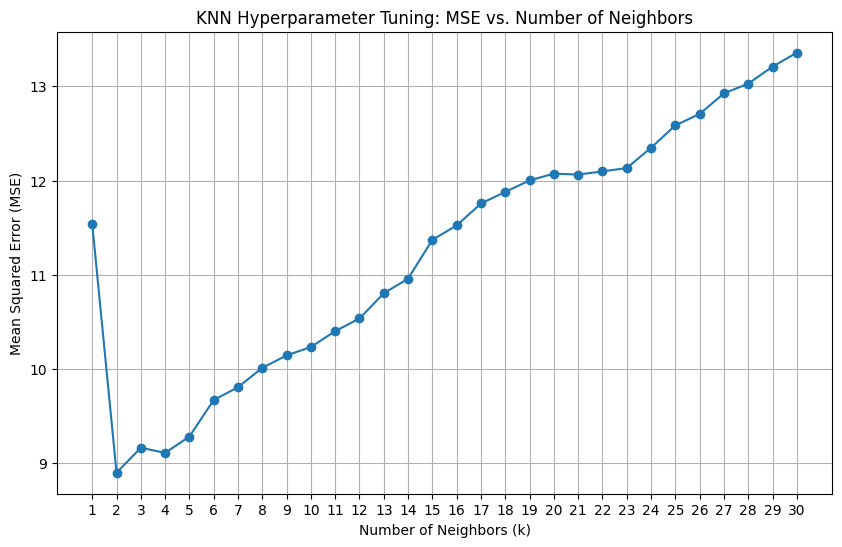

In [74]:
from sklearn.model_selection import cross_val_score

# KNN Hyperparameter Tuning
def knn_hyperparameter_tuning(X_train, y_train):
    k_values = range(1, 31)  # Example range for k
    mse_values = []
    
    for k in k_values:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        mse = -cross_val_score(knn_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
        mse_values.append(mse)
    
    return k_values, mse_values

# Perform KNN Hyperparameter Tuning
k_values, mse_values = knn_hyperparameter_tuning(X_train_scaled, y_train)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mse_values, marker='o', linestyle='-')
plt.title('KNN Hyperparameter Tuning: MSE vs. Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.show()